## Setup 

Here we install the relevant packages and retrieve the relevant model files to run the inference code. 

### Warning: This will take a while to download, and will contain ~ 14.655 GB of model files you will need to run the demo. Be wary of the associated chance this could make you go over the data storage limit for your Gradient account.

In [ ]:
!apt-get update && apt-get install git-lfs -y
!git-lfs clone https://huggingface.co/spaces/shi-labs/Versatile-Diffusion

!mv Versatile-Diffusion/pretrained ./
!rm -r Versatile-Diffusion

In [ ]:
!pip install -r requirement.txt

!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!cp -r src/taming-transformers/taming ./

# Instantiate model inference class and functions

In [5]:
# import gradio as gr
import os
import PIL
from PIL import Image
from pathlib import Path
import numpy as np
import numpy.random as npr
from contextlib import nullcontext

import torch
import torchvision.transforms as tvtrans
from lib.cfg_helper import model_cfg_bank
from lib.model_zoo import get_model
from lib.model_zoo.ddim_vd import DDIMSampler_VD, DDIMSampler_VD_DualContext
from lib.model_zoo.ddim_dualcontext import DDIMSampler_DualContext

from lib.experiments.sd_default import color_adjust

n_sample_image = 2
n_sample_text = 4
cache_examples = True

class vd_inference(object):
    def __init__(self, type='official'):
        if type in ['dc', '2-flow']:
            cfgm_name = 'vd_dc_noema'
            sampler = DDIMSampler_DualContext
            pth = 'pretrained/vd-dc.pth'
        elif type in ['official', '4-flow']:
            cfgm_name = 'vd_noema'
            sampler = DDIMSampler_VD
            pth = 'pretrained/vd-official.pth'
        cfgm = model_cfg_bank()(cfgm_name)
        net = get_model()(cfgm)

        sd = torch.load(pth, map_location='cpu')
        net.load_state_dict(sd, strict=False)
        
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            net.to('cuda')
        self.model_name = cfgm_name
        self.net = net
        self.sampler = sampler(net)

    def regularize_image(self, x):
        BICUBIC = PIL.Image.Resampling.BICUBIC
        if isinstance(x, str):
            x = Image.open(x).resize([512, 512], resample=BICUBIC)
            x = tvtrans.ToTensor()(x)
        elif isinstance(x, PIL.Image.Image):
            x = x.resize([512, 512], resample=BICUBIC)
            x = tvtrans.ToTensor()(x)
        elif isinstance(x, np.ndarray):
            x = PIL.Image.fromarray(x).resize([512, 512], resample=BICUBIC)
            x = tvtrans.ToTensor()(x)
        elif isinstance(x, torch.Tensor):
            pass
        else:
            assert False, 'Unknown image type'

        assert (x.shape[1]==512) & (x.shape[2]==512), \
            'Wrong image size'
        if self.use_cuda:
            x = x.to('cuda')
        return x

    def decode(self, z, xtype, ctype, color_adj='None', color_adj_to=None):
        net = self.net
        if xtype == 'image':
            x = net.autokl_decode(z)

            color_adj_flag = (color_adj!='None') and (color_adj is not None)
            color_adj_simple = color_adj=='Simple'
            color_adj_keep_ratio = 0.5

            if color_adj_flag and (ctype=='vision'):
                x_adj = []
                for xi in x:
                    color_adj_f = color_adjust(ref_from=(xi+1)/2, ref_to=color_adj_to)
                    xi_adj = color_adj_f((xi+1)/2, keep=color_adj_keep_ratio, simple=color_adj_simple)
                    x_adj.append(xi_adj)
                x = x_adj
            else:
                x = torch.clamp((x+1.0)/2.0, min=0.0, max=1.0)
                x = [tvtrans.ToPILImage()(xi) for xi in x]
            return x

        elif xtype == 'text':
            prompt_temperature = 1.0
            prompt_merge_same_adj_word = True
            x = net.optimus_decode(z, temperature=prompt_temperature)
            if prompt_merge_same_adj_word:
                xnew = []
                for xi in x:
                    xi_split = xi.split()
                    xinew = []
                    for idxi, wi in enumerate(xi_split):
                        if idxi!=0 and wi==xi_split[idxi-1]:
                            continue
                        xinew.append(wi)
                    xnew.append(' '.join(xinew))
                x = xnew
            return x

    def inference(self, xtype, cin, steps, ctype, h = 512, w = 512, scale=7.5, n_samples=None, color_adj=None):
        net = self.net
        sampler = self.sampler
        ddim_steps = steps
        ddim_eta = 0.0

        if xtype == 'image':
            n_samples = n_sample_image if n_samples is None else n_samples
        elif xtype == 'text':
            n_samples = n_sample_text if n_samples is None else n_samples

        if ctype in ['prompt', 'text']:
            c = net.clip_encode_text(n_samples * [cin])
            u = None
            if scale != 1.0:
                u = net.clip_encode_text(n_samples * [""])

        elif ctype in ['vision', 'image']:
            cin = self.regularize_image(cin)
            ctemp = cin*2 - 1
            ctemp = ctemp[None].repeat(n_samples, 1, 1, 1)
            c = net.clip_encode_vision(ctemp)
            u = None
            if scale != 1.0:
                dummy = torch.zeros_like(ctemp)
                u = net.clip_encode_vision(dummy)

        if xtype == 'image':
            shape = [n_samples, 4, h//8, w//8]
            z, _ = sampler.sample(
                steps=ddim_steps,
                shape=shape,
                conditioning=c,
                unconditional_guidance_scale=scale,
                unconditional_conditioning=u,
                xtype=xtype, ctype=ctype,
                eta=ddim_eta,
                verbose=False,)
            x = self.decode(z, xtype, ctype, color_adj=color_adj, color_adj_to=cin)
            return x

        elif xtype == 'text':
            n = 768
            shape = [n_samples, n]
            z, _ = sampler.sample(
                steps=ddim_steps,
                shape=shape,
                conditioning=c,
                unconditional_guidance_scale=scale,
                unconditional_conditioning=u,
                xtype=xtype, ctype=ctype,
                eta=ddim_eta,
                verbose=False,)
            x = self.decode(z, xtype, ctype)
            return x

    def application_disensemble(self, cin, h = 512, w = 512, n_samples=None, level=0, color_adj=None,steps = None, scale = None):
        net = self.net
        scale = scale
        sampler = self.sampler
        ddim_steps = steps
        ddim_eta = 0.0
        n_samples = n_sample_image if n_samples is None else n_samples

        cin = self.regularize_image(cin)
        ctemp = cin*2 - 1
        ctemp = ctemp[None].repeat(n_samples, 1, 1, 1)
        c = net.clip_encode_vision(ctemp)
        u = None
        if scale != 1.0:
            dummy = torch.zeros_like(ctemp)
            u = net.clip_encode_vision(dummy)

        if level == 0:
            pass
        else:
            c_glb = c[:, 0:1]
            c_loc = c[:, 1: ]
            u_glb = u[:, 0:1]
            u_loc = u[:, 1: ]

            if level == -1:
                c_loc = self.remove_low_rank(c_loc, demean=True, q=50, q_remove=1)
                u_loc = self.remove_low_rank(u_loc, demean=True, q=50, q_remove=1)
            if level == -2:
                c_loc = self.remove_low_rank(c_loc, demean=True, q=50, q_remove=2)
                u_loc = self.remove_low_rank(u_loc, demean=True, q=50, q_remove=2)
            if level == 1:
                c_loc = self.find_low_rank(c_loc, demean=True, q=10)
                u_loc = self.find_low_rank(u_loc, demean=True, q=10)
            if level == 2:
                c_loc = self.find_low_rank(c_loc, demean=True, q=2)
                u_loc = self.find_low_rank(u_loc, demean=True, q=2)

            c = torch.cat([c_glb, c_loc], dim=1)
            u = torch.cat([u_glb, u_loc], dim=1)

        shape = [n_samples, 4, h//8, w//8]
        z, _ = sampler.sample(
            steps=ddim_steps,
            shape=shape,
            conditioning=c,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=u,
            xtype='image', ctype='vision',
            eta=ddim_eta,
            verbose=False,)
        x = self.decode(z, 'image', 'vision', color_adj=color_adj, color_adj_to=cin)
        return x

    def find_low_rank(self, x, demean=True, q=20, niter=10):
        if demean:
            x_mean = x.mean(-1, keepdim=True)
            x_input = x - x_mean
        else:
            x_input = x

        u, s, v = torch.pca_lowrank(x_input, q=q, center=False, niter=niter)
        ss = torch.stack([torch.diag(si) for si in s])
        x_lowrank = torch.bmm(torch.bmm(u, ss), torch.permute(v, [0, 2, 1]))        

        if demean:
            x_lowrank += x_mean
        return x_lowrank

    def remove_low_rank(self, x, demean=True, q=20, niter=10, q_remove=10):
        if demean:
            x_mean = x.mean(-1, keepdim=True)
            x_input = x - x_mean
        else:
            x_input = x

        u, s, v = torch.pca_lowrank(x_input, q=q, center=False, niter=niter)
        s[:, 0:q_remove] = 0
        ss = torch.stack([torch.diag(si) for si in s])
        x_lowrank = torch.bmm(torch.bmm(u, ss), torch.permute(v, [0, 2, 1]))        

        if demean:
            x_lowrank += x_mean
        return x_lowrank

    def application_dualguided(self, cim, ctx, h = 512, w = 512, n_samples=None, mixing=0.5, color_adj=None, steps = None, scale = None):
        net = self.net
        scale = scale
        sampler = DDIMSampler_VD_DualContext(net)
        ddim_steps = steps
        ddim_eta = 0.0
        n_samples = n_sample_image if n_samples is None else n_samples

        ctemp0 = self.regularize_image(cim)
        ctemp1 = ctemp0*2 - 1
        ctemp1 = ctemp1[None].repeat(n_samples, 1, 1, 1)
        cim = net.clip_encode_vision(ctemp1)
        uim = None
        if scale != 1.0:
            dummy = torch.zeros_like(ctemp1)
            uim = net.clip_encode_vision(dummy)

        ctx = net.clip_encode_text(n_samples * [ctx])
        utx = None
        if scale != 1.0:
            utx = net.clip_encode_text(n_samples * [""])

        shape = [n_samples, 4, h//8, w//8]

        z, _ = sampler.sample_dc(
            steps=ddim_steps,
            shape=shape,
            first_conditioning=[uim, cim],
            second_conditioning=[utx, ctx],
            unconditional_guidance_scale=scale,
            xtype='image', 
            first_ctype='vision',
            second_ctype='prompt',
            eta=ddim_eta,
            verbose=False,
            mixed_ratio=(1-mixing), )
        x = self.decode(z, 'image', 'vision', color_adj=color_adj, color_adj_to=ctemp0)
        return x

    def application_i2t2i(self, cim, ctx_n, ctx_p, steps, scale, h = 512, w = 512, n_samples=None, color_adj=None,):
        net = self.net
        scale = scale
        sampler = DDIMSampler_VD_DualContext(net)
        ddim_steps = steps
        ddim_eta = 0.0
        prompt_temperature = 1.0
        n_samples = n_sample_image if n_samples is None else n_samples

        ctemp0 = self.regularize_image(cim)
        ctemp1 = ctemp0*2 - 1
        ctemp1 = ctemp1[None].repeat(n_samples, 1, 1, 1)
        cim = net.clip_encode_vision(ctemp1)
        uim = None
        if scale != 1.0:
            dummy = torch.zeros_like(ctemp1)
            uim = net.clip_encode_vision(dummy)

        n = 768
        shape = [n_samples, n]
        zt, _ = sampler.sample(
            steps=ddim_steps,
            shape=shape,
            conditioning=cim,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=uim,
            xtype='text', ctype='vision',
            eta=ddim_eta,
            verbose=False,)
        ztn = net.optimus_encode([ctx_n])
        ztp = net.optimus_encode([ctx_p])

        ztn_norm = ztn / ztn.norm(dim=1)
        zt_proj_mag = torch.matmul(zt, ztn_norm[0])
        zt_perp = zt - zt_proj_mag[:, None] * ztn_norm
        zt_newd = zt_perp + ztp
        ctx_new = net.optimus_decode(zt_newd, temperature=prompt_temperature)

        ctx_new = net.clip_encode_text(ctx_new)
        ctx_p = net.clip_encode_text([ctx_p])
        ctx_new = torch.cat([ctx_new, ctx_p.repeat(n_samples, 1, 1)], dim=1)
        utx_new = net.clip_encode_text(n_samples * [""])
        utx_new = torch.cat([utx_new, utx_new], dim=1)

        cim_loc = cim[:, 1: ]
        cim_loc_new = self.find_low_rank(cim_loc, demean=True, q=10)
        cim_new = cim_loc_new
        uim_new = uim[:, 1:]
        
        shape = [n_samples, 4, h//8, w//8]
        z, _ = sampler.sample_dc(
            steps=ddim_steps,
            shape=shape,
            first_conditioning=[uim_new, cim_new],
            second_conditioning=[utx_new, ctx_new],
            unconditional_guidance_scale=scale,
            xtype='image', 
            first_ctype='vision',
            second_ctype='prompt',
            eta=ddim_eta,
            verbose=False,
            mixed_ratio=0.33, )

        x = self.decode(z, 'image', 'vision', color_adj=color_adj, color_adj_to=ctemp0)
        return x

vd_inference = vd_inference('official')





#######################
# Running in eps mode #
#######################

Load openai_unet_2d with total 859520964 parameters,100401.143 parameter sum.
Load openai_unet_0dmd with total 1708848448 parameters,249428.145 parameter sum.
Load openai_unet_vd with total 2566318852 parameters,349814.766 parameter sum.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Load pth from pretrained/kl-f8.pth
Load autoencoderkl with total 83653863 parameters,72921.759 parameter sum.
Load optimus_bert_connector with total 109489920 parameters,19252.003 parameter sum.
Load optimus_gpt2_connector with total 132109824 parameters,19073.698 parameter sum.
Load pth from pretrained/optimus-vae.pth
Load optimus_vae with total 241599744 parameters,-344611.688 parameter sum.


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Load clip_frozen with total 427616513 parameters,64007.510 parameter sum.
Load vd with total 3319188972 parameters,142132.348 parameter sum.


In [9]:
def main(mode,
         image=None,
         prompt=None,
         nprompt=None,
         pprompt=None,
         color_adj=None,
         disentanglement_level=None,
         dual_guided_mixing=None,
         seed=0,
         steps=50,
         n_samples = 1,
         scale = 7.5, 
         h = 512,
         w = 512):

    if seed<0:
        seed = 0
    np.random.seed(seed)
    torch.manual_seed(seed+100)

    if mode == 'Text-to-Image':
        if (prompt is None) or (prompt == ""):
            return None, None
        with torch.no_grad():
            rv = vd_inference.inference(n_samples = n_samples, steps = steps,
                xtype = 'image',
                cin = prompt,
                ctype = 'prompt',
                scale = scale)
        return rv, None
    elif mode == 'Image-Variation':
        if image is None:
            return None, None
        with torch.no_grad():
            rv = vd_inference.inference(n_samples = n_samples, steps = steps,
                xtype = 'image',
                cin = image,
                ctype = 'vision',
                color_adj = color_adj,
                scale = scale)
        return rv, None
    elif mode == 'Image-to-Text':
        if image is None:
            return None, None
        with torch.no_grad():
            rv = vd_inference.inference(n_samples = n_samples, steps = steps,
                xtype = 'text',
                cin = image,
                ctype = 'vision',
                scale = scale)
        return None, '\n'.join(rv)
    elif mode == 'Text-Variation':
        if prompt is None:
            return None, None
        with torch.no_grad():
            rv = vd_inference.inference(n_samples = n_samples, steps = steps,
                xtype = 'text',
                cin = prompt,
                ctype = 'prompt',
                scale = scale)
        return None, '\n'.join(rv)
    elif mode == 'Disentanglement':
        if image is None:
            return None, None
        with torch.no_grad():
            rv = vd_inference.application_disensemble(
                n_samples = n_samples, 
                cin = image,
                level = disentanglement_level,
                color_adj = color_adj,
                steps = steps,
                scale = scale)
        return rv, None
    elif mode == 'Dual-Guided':
        if (image is None) or (prompt is None) or (prompt==""):
            return None, None
        with torch.no_grad():
            rv = vd_inference.application_dualguided(
                n_samples = n_samples, 
                cim = image,
                ctx = prompt,
                mixing = dual_guided_mixing,
                color_adj = color_adj,
                steps = steps,
                scale = scale)
        return rv, None
    elif mode == 'Latent-I2T2I':
        if (image is None) or (nprompt is None) or (nprompt=="") \
                or (pprompt is None) or (pprompt==""):
            return None, None
        with torch.no_grad():
            rv = vd_inference.application_i2t2i(
                n_samples = n_samples, 
                cim = image,
                ctx_n = nprompt,
                ctx_p = pprompt,
                color_adj = color_adj, 
                steps = steps,
                scale = scale)
        return rv, None
    else:
        assert False, "No such mode!"

def get_instruction(mode):
    t2i_instruction = ["Generate image from text prompt."]
    i2i_instruction = [
        "Generate image conditioned on reference image.", 
        "Color Calibration provide an opinion to adjust image color according to reference image.", ]
    i2t_instruction = ["Generate text from reference image."]
    t2t_instruction = ["Generate text from reference text prompt. (Model insufficiently trained, thus results are still experimental)"]
    dis_instruction = [
        "Generate a variation of reference image that disentangled for semantic or style.",
        "Color Calibration provide an opinion to adjust image color according to reference image.",
        "Disentanglement level controls the level of focus towards semantic (-2, -1) or style (1 2). Level 0 serves as Image-Variation.", ]
    dug_instruction = [
        "Generate image from dual guidance of reference image and text prompt.",
        "Color Calibration provide an opinion to adjust image color according to reference image.",
        "Guidance Mixing provides linear balances between image and text context. (0 towards image, 1 towards text)", ]
    iti_instruction = [
        "Generate image variations via image-to-text, text-latent-editing, and then text-to-image. (Still under exploration)",
        "Color Calibration provide an opinion to adjust image color according to reference image.",
        "Input prompt that will be substract from text/text latent code.",
        "Input prompt that will be added to text/text latent code.", ]

    if mode == "Text-to-Image":
        return '\n'.join(t2i_instruction)
    elif mode == "Image-Variation":
        return '\n'.join(i2i_instruction)
    elif mode == "Image-to-Text":
        return '\n'.join(i2t_instruction)
    elif mode == "Text-Variation":
        return '\n'.join(t2t_instruction)
    elif mode == "Disentanglement":
        return '\n'.join(dis_instruction)
    elif mode == "Dual-Guided":
        return '\n'.join(dug_instruction)
    elif mode == "Latent-I2T2I":
        return '\n'.join(iti_instruction)

#############
# Interface #
#############


## Call the function 

- Change mode to any of the tasks described in the `get_instructions()` output.
- prompt (str) is used to guide the generation process
- nprompt (str) is the negative prompt, and contains words we do not want represented in our synthesized outputs.
- pprompt (str) the positive prompt (used in dual guided/latent i2t2i)
- seed (int) controls randomness of generation
- steps (int) number of ddim sampling steps
- n_samples (int) number of images generated each batch
- scale (int) guidance scale of the model 0-30, 0 no guidance, 30 max guidance
- h (int) height, in pixels
- w (int) width, in pixels

In [30]:
x = main(mode = 'Text-to-Image',
         image=None,
         prompt= 'a magical fantasy castle overlooking a golden gold colored oceans and giant crashing tsunami waves',
         nprompt='low contrast, blurry, out of frame, text, watermark, distortion, black and white, low resolution, low detail, closeup, out of focus, bad framing, tiling, grainy, grayscale, monotone, watermarked',
         pprompt='a magical fantasy castle overlooking a golden gold colored oceans and giant crashing tsunami waves',
         color_adj=None,
         disentanglement_level=None,
         dual_guided_mixing=None,
         seed=552523,
         steps = 50,
         n_samples = 1,
         scale = 7.5,
         h = 512,
         w = 512)

DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for DDIM sampling is [5, 4, 64, 64], eta 0.0


DDIM Sampler: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


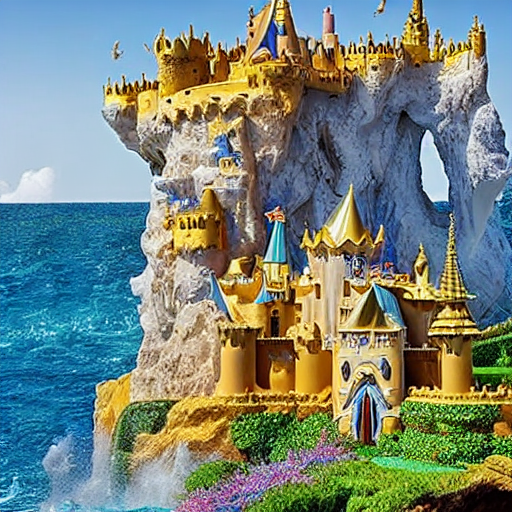

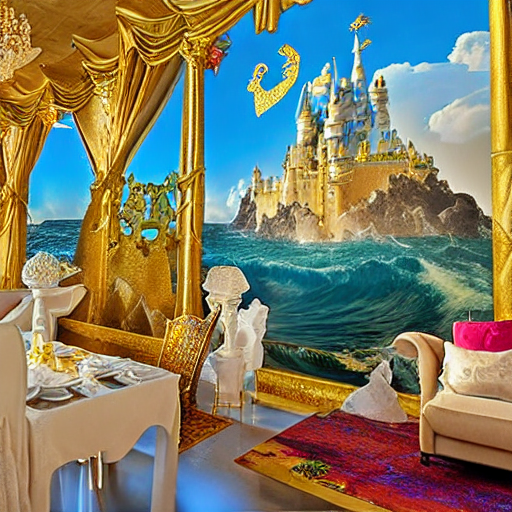

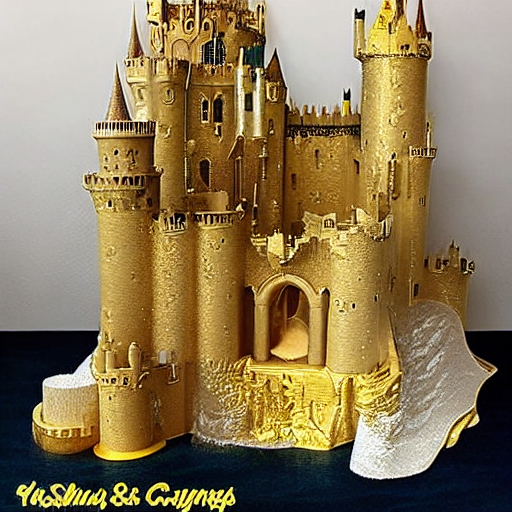

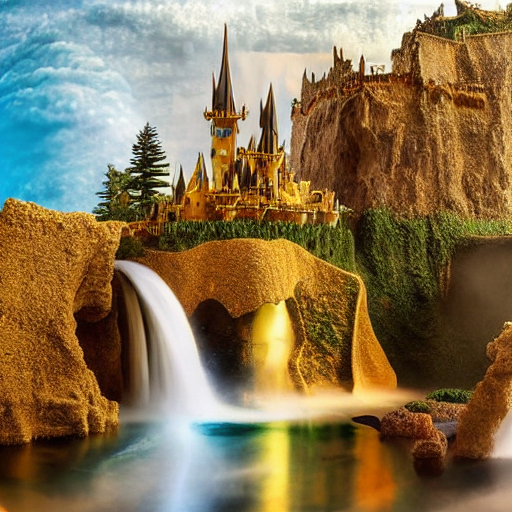

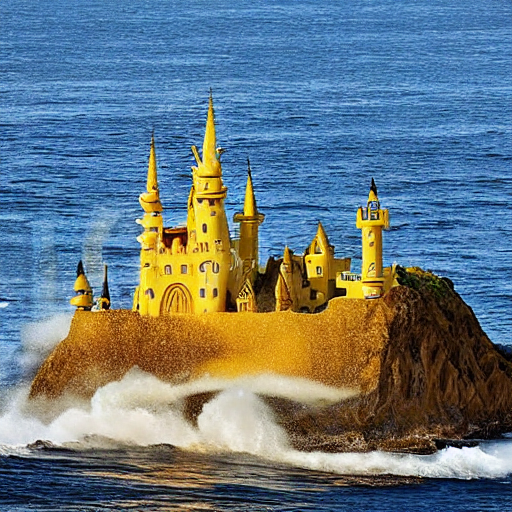

([<PIL.Image.Image image mode=RGB size=512x512 at 0x7F26AF167850>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F26AF050EB0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F26AF050B50>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F2A54486B50>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F2A54486190>], None)


In [31]:
# display(Image.open(x[0][0]))
# # display(Image.open(x[1]))
for i in x[0]:
    display(i)
print(x)

# Save your images to outputs

In [32]:
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [33]:
try:
    num = int(sorted(os.listdir('outputs'))[-1].split('-')[1].split('.')[0])
except: 
    num = 0
for i in x[0]:
    i.save(f'outputs/image-{num}.png')
    num +=1